In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [91]:
def get_stock_data(stock_name,shift_window, normalized=0):
    from pandas_datareader import data

    # Only get the adjusted close.
    df = data.DataReader(stock_name,
                       start='2017-1-1',
                       end='2018-08-20',
                       data_source='yahoo')

    df['Adj Close'] = df['Adj Close'].shift(-shift_window)
    df['Difference'] = ( df['Adj Close'].shift(-shift_window) / df['Adj Close'] ) 
    df['Difference'] = df['Difference'] * 10000 - 10000
    print(df.head())
    df = df[shift_window*2:-shift_window*2]
    return df

In [92]:
stock_name = 'TS.BA'
df = get_stock_data(stock_name,5,1)




                  High         Low        Open       Close   Volume  \
Date                                                                  
2017-01-02  285.000000  281.000000  281.000000  284.000000  12161.0   
2017-01-03  289.000000  283.000000  284.000000  285.000000  40930.0   
2017-01-04  289.500000  283.049988  284.899994  288.500000  71984.0   
2017-01-05  290.200012  288.000000  288.649994  288.000000  32706.0   
2017-01-06  288.000000  283.600006  287.950012  284.299988  24804.0   

             Adj Close  Difference  
Date                                
2017-01-02  280.925018  106.382690  
2017-01-03  278.932617  107.143670  
2017-01-04  282.817749   91.581518  
2017-01-05  282.668335   79.295212  
2017-01-06  282.917358  211.268137  


In [93]:
print(df.head(5))
df_val = df.values
df_val[3]

                  High         Low        Open  Close   Volume   Adj Close  \
Date                                                                         
2017-01-16  285.500000  283.250000  284.000000  285.0  11588.0  285.905945   
2017-01-17  284.600006  280.000000  284.500000  283.0  15736.0  290.886841   
2017-01-18  288.950012  280.000000  283.200012  286.5  23484.0  293.875427   
2017-01-19  288.950012  285.500000  286.399994  286.0  22531.0  291.285370   
2017-01-20  290.500000  286.399994  286.399994  290.0  35837.0  287.350403   

            Difference  
Date                    
2017-01-16 -357.143238  
2017-01-17 -520.548103  
2017-01-18 -576.271767  
2017-01-19 -560.877978  
2017-01-20 -466.285850  


array([  288.95001221,   285.5       ,   286.3999939 ,   286.        ,
       22531.        ,   291.28536987,  -560.87797814])

In [94]:
def load_data(stock, seq_len):

    data = stock
    amount_of_features = len(data[::-1][0]) - 1
    
    
    sequence_length = seq_len 
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length + 1])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    print ("x_test:",x_test)
    y_test = result[int(row):, -1][:,-1]
    print ("y_test:",y_test)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [95]:
def load_data_v2(stock, seq_len):

    data_x = stock
    data_y = stock
    #print("DATA Y 0 :",data_y)
    print ("Amount of features TOT :",len(data_x[0]) )
    data_x = np.delete(data_x,np.s_[len(stock[0])-1],axis=1)
    data_y = np.delete(data_y,np.s_[0:len(stock[0])-1],axis=1)
    #print("DATA Y :",data_y)
    amount_of_features = len(data_x[0]) 
    
    print ("Amount of features found:",amount_of_features)
    
    sequence_length = seq_len 
    result_x = []
    result_y = []
    for index in range(len(data_x) - sequence_length ):
        result_x.append(data_x[index: index + sequence_length + 1])
        result_y.append(data_y[index: index + sequence_length + 1])

    result_x = np.array(result_x)
    result_y = np.array(result_y)
    
    row = round(0.92 * result_x.shape[0])
    train_x = result_x[:int(row), :]
    train_y = result_y[:int(row), :]
    
    x_train = train_x[:, :-1]
    x_test = result_x[int(row):, :-1]
   
    y_train = train_y[:, -1]
    y_test = result_y[int(row):, -1]
    
    #print ("x_test before:",x_test)
    #print ("y_test before:",y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    print ("x_test:",x_test)
    print ("y_test:",y_test)

    return [x_train, y_train, x_test, y_test]

In [96]:
load_data_v2(df_val, 5)

Amount of features TOT : 7
Amount of features found: 6
x_test: [[[   507.8500061     485.            507.8500061     503.29998779
    38753.            476.04998779]
  [   497.95001221    476.04998779    497.95001221    481.1000061
    59136.            481.        ]
  [   488.            480.            481.            487.1499939
    50405.            500.5       ]
  [   500.            476.04998779    499.95001221    480.29998779
   101013.            516.34997559]
  [   502.5           489.04998779    489.04998779    493.8999939
    52305.            521.95001221]]

 [[   497.95001221    476.04998779    497.95001221    481.1000061
    59136.            481.        ]
  [   488.            480.            481.            487.1499939
    50405.            500.5       ]
  [   500.            476.04998779    499.95001221    480.29998779
   101013.            516.34997559]
  [   502.5           489.04998779    489.04998779    493.8999939
    52305.            521.95001221]
  [   494.5   

[array([[[   285.5       ,    283.25      ,    284.        ,
             285.        ,  11588.        ,    285.90594482],
         [   284.6000061 ,    280.        ,    284.5       ,
             283.        ,  15736.        ,    290.88684082],
         [   288.95001221,    280.        ,    283.20001221,
             286.5       ,  23484.        ,    293.87542725],
         [   288.95001221,    285.5       ,    286.3999939 ,
             286.        ,  22531.        ,    291.28536987],
         [   290.5       ,    286.3999939 ,    286.3999939 ,
             290.        ,  35837.        ,    287.35040283]],
 
        [[   284.6000061 ,    280.        ,    284.5       ,
             283.        ,  15736.        ,    290.88684082],
         [   288.95001221,    280.        ,    283.20001221,
             286.5       ,  23484.        ,    293.87542725],
         [   288.95001221,    285.5       ,    286.3999939 ,
             286.        ,  22531.        ,    291.28536987],
         [   

In [97]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [98]:
len(df_val[0])

7

In [99]:
df_val = df.values / 1000
#for a in range(len(df_val[0])-2):
#    df_val[:,a] /= 1000
window  =  5
X_train, y_train, X_test, y_test = load_data_v2(df_val[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

Amount of features TOT : 7
Amount of features found: 6
x_test: [[[ 0.254       0.249       0.252       0.252      39.183
    0.24137633]
  [ 0.256       0.248       0.256       0.25089999 25.495
    0.2465565 ]
  [ 0.25595     0.253       0.253       0.254      26.239
    0.24356793]
  [ 0.2585      0.25205     0.2585      0.253       9.733
    0.23808891]
  [ 0.263       0.253       0.253       0.2585     17.803
    0.24700479]]

 [[ 0.256       0.248       0.256       0.25089999 25.495
    0.2465565 ]
  [ 0.25595     0.253       0.253       0.254      26.239
    0.24356793]
  [ 0.2585      0.25205     0.2585      0.253       9.733
    0.23808891]
  [ 0.263       0.253       0.253       0.2585     17.803
    0.24700479]
  [ 0.25689999  0.251       0.25689999  0.25539999 12.527
    0.25103935]]

 [[ 0.25595     0.253       0.253       0.254      26.239
    0.24356793]
  [ 0.2585      0.25205     0.2585      0.253       9.733
    0.23808891]
  [ 0.263       0.253       0.253       0.258

In [100]:
# model = build_model([3,lag,1])
#model = build_model2([3,window,1])
model = build_model2([len(df_val[0])-1,5,1])

model.fit(
    X_train,
    y_train,
    batch_size=576,
    epochs=250,
    validation_split=0.1,
    verbose=1)

Train on 309 samples, validate on 35 samples
Epoch 1/250
309/309 [==============================] - 9s 29ms/step - loss: 0.2389 - acc: 0.0032 - val_loss: 0.1511 - val_acc: 0.0000e+00
Epoch 2/250
309/309 [==============================] - 0s 612us/step - loss: 0.2371 - acc: 0.0032 - val_loss: 0.1519 - val_acc: 0.0000e+00
Epoch 3/250
309/309 [==============================] - 0s 647us/step - loss: 0.2352 - acc: 0.0032 - val_loss: 0.1529 - val_acc: 0.0000e+00
Epoch 4/250
309/309 [==============================] - 0s 611us/step - loss: 0.2332 - acc: 0.0032 - val_loss: 0.1542 - val_acc: 0.0000e+00
Epoch 5/250
309/309 [==============================] - 0s 650us/step - loss: 0.2315 - acc: 0.0032 - val_loss: 0.1558 - val_acc: 0.0000e+00
Epoch 6/250
309/309 [==============================] - 0s 658us/step - loss: 0.2305 - acc: 0.0032 - val_loss: 0.1579 - val_acc: 0.0000e+00
Epoch 7/250
309/309 [==============================] - 0s 630us/step - loss: 0.2283 - acc: 0.0032 - val_loss: 0.1606 - val

Epoch 60/250
309/309 [==============================] - 0s 650us/step - loss: 0.2127 - acc: 0.0032 - val_loss: 0.1678 - val_acc: 0.0000e+00
Epoch 61/250
309/309 [==============================] - 0s 668us/step - loss: 0.2102 - acc: 0.0032 - val_loss: 0.1736 - val_acc: 0.0000e+00
Epoch 62/250
309/309 [==============================] - 0s 626us/step - loss: 0.2098 - acc: 0.0032 - val_loss: 0.1755 - val_acc: 0.0000e+00
Epoch 63/250
309/309 [==============================] - 0s 642us/step - loss: 0.2089 - acc: 0.0032 - val_loss: 0.1776 - val_acc: 0.0000e+00
Epoch 64/250
309/309 [==============================] - 0s 611us/step - loss: 0.2107 - acc: 0.0032 - val_loss: 0.1899 - val_acc: 0.0000e+00
Epoch 65/250
309/309 [==============================] - 0s 608us/step - loss: 0.2076 - acc: 0.0032 - val_loss: 0.2060 - val_acc: 0.0000e+00
Epoch 66/250
309/309 [==============================] - 0s 644us/step - loss: 0.2103 - acc: 0.0032 - val_loss: 0.2021 - val_acc: 0.0000e+00
Epoch 67/250
309/309

Epoch 119/250
309/309 [==============================] - 0s 666us/step - loss: 0.1688 - acc: 0.0032 - val_loss: 0.1777 - val_acc: 0.0000e+00
Epoch 120/250
309/309 [==============================] - 0s 664us/step - loss: 0.1736 - acc: 0.0032 - val_loss: 0.1824 - val_acc: 0.0000e+00
Epoch 121/250
309/309 [==============================] - 0s 671us/step - loss: 0.1707 - acc: 0.0032 - val_loss: 0.2073 - val_acc: 0.0000e+00
Epoch 122/250
309/309 [==============================] - 0s 690us/step - loss: 0.1693 - acc: 0.0032 - val_loss: 0.2064 - val_acc: 0.0000e+00
Epoch 123/250
309/309 [==============================] - 0s 645us/step - loss: 0.1623 - acc: 0.0032 - val_loss: 0.2192 - val_acc: 0.0000e+00
Epoch 124/250
309/309 [==============================] - 0s 643us/step - loss: 0.1726 - acc: 0.0032 - val_loss: 0.2629 - val_acc: 0.0000e+00
Epoch 125/250
309/309 [==============================] - 0s 631us/step - loss: 0.1675 - acc: 0.0032 - val_loss: 0.2374 - val_acc: 0.0000e+00
Epoch 126/250

Epoch 178/250
309/309 [==============================] - 0s 601us/step - loss: 0.1427 - acc: 0.0032 - val_loss: 0.2863 - val_acc: 0.0000e+00
Epoch 179/250
309/309 [==============================] - 0s 743us/step - loss: 0.1583 - acc: 0.0032 - val_loss: 0.2818 - val_acc: 0.0000e+00
Epoch 180/250
309/309 [==============================] - 0s 628us/step - loss: 0.1493 - acc: 0.0032 - val_loss: 0.2223 - val_acc: 0.0000e+00
Epoch 181/250
309/309 [==============================] - 0s 734us/step - loss: 0.1453 - acc: 0.0032 - val_loss: 0.2034 - val_acc: 0.0000e+00
Epoch 182/250
309/309 [==============================] - 0s 887us/step - loss: 0.1414 - acc: 0.0032 - val_loss: 0.2060 - val_acc: 0.0000e+00
Epoch 183/250
309/309 [==============================] - 0s 613us/step - loss: 0.1481 - acc: 0.0032 - val_loss: 0.2047 - val_acc: 0.0000e+00
Epoch 184/250
309/309 [==============================] - 0s 670us/step - loss: 0.1365 - acc: 0.0032 - val_loss: 0.2509 - val_acc: 0.0000e+00
Epoch 185/250

Epoch 237/250
309/309 [==============================] - 0s 943us/step - loss: 0.1374 - acc: 0.0032 - val_loss: 0.2480 - val_acc: 0.0000e+00
Epoch 238/250
309/309 [==============================] - 0s 769us/step - loss: 0.1303 - acc: 0.0032 - val_loss: 0.2946 - val_acc: 0.0000e+00
Epoch 239/250
309/309 [==============================] - 0s 863us/step - loss: 0.1372 - acc: 0.0032 - val_loss: 0.2861 - val_acc: 0.0000e+00
Epoch 240/250
309/309 [==============================] - 0s 719us/step - loss: 0.1384 - acc: 0.0032 - val_loss: 0.2679 - val_acc: 0.0000e+00
Epoch 241/250
309/309 [==============================] - 0s 788us/step - loss: 0.1397 - acc: 0.0032 - val_loss: 0.2773 - val_acc: 0.0000e+00
Epoch 242/250
309/309 [==============================] - 0s 794us/step - loss: 0.1265 - acc: 0.0032 - val_loss: 0.2715 - val_acc: 0.0000e+00
Epoch 243/250
309/309 [==============================] - 0s 682us/step - loss: 0.1350 - acc: 0.0032 - val_loss: 0.2462 - val_acc: 0.0000e+00
Epoch 244/250

In [104]:
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

print (X_test)

#testScore = model.evaluate(X_test, y_test, verbose=1)
#print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

344/344 [==============================] - 0s 920us/step
Train Score: 0.14 MSE (0.37 RMSE)
[[[ 0.254       0.249       0.252       0.252      39.183
    0.24137633]
  [ 0.256       0.248       0.256       0.25089999 25.495
    0.2465565 ]
  [ 0.25595     0.253       0.253       0.254      26.239
    0.24356793]
  [ 0.2585      0.25205     0.2585      0.253       9.733
    0.23808891]
  [ 0.263       0.253       0.253       0.2585     17.803
    0.24700479]]

 [[ 0.256       0.248       0.256       0.25089999 25.495
    0.2465565 ]
  [ 0.25595     0.253       0.253       0.254      26.239
    0.24356793]
  [ 0.2585      0.25205     0.2585      0.253       9.733
    0.23808891]
  [ 0.263       0.253       0.253       0.2585     17.803
    0.24700479]
  [ 0.25689999  0.251       0.25689999  0.25539999 12.527
    0.25103935]]

 [[ 0.25595     0.253       0.253       0.254      26.239
    0.24356793]
  [ 0.2585      0.25205     0.2585      0.253       9.733
    0.23808891]
  [ 0.263       0

In [105]:
print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print ("pred",p)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

[[ 0.29395001  0.286       0.291       0.287      38.158       0.27569501]
 [ 0.2905      0.28639999  0.28639999  0.29       35.837       0.2873504 ]
 [ 0.28895001  0.2855      0.28639999  0.286      22.531       0.29128537]
 [ 0.28895001  0.28        0.28320001  0.2865     23.484       0.29387543]
 [ 0.28460001  0.28        0.2845      0.283      15.736       0.29088684]]
pred [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.12679464]
 [0.08343387]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.06557583]
 [0.        ]
 [0.        ]
 [0.0011571 ]]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


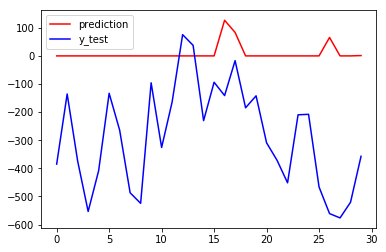

In [106]:
import matplotlib.pyplot as plt2

plt2.plot((p * 1000 ) ,color='red', label='prediction')
plt2.plot(y_test * 1000,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [107]:
def load_data_last(stock_name, seq_len, window ):
    from pandas_datareader import data

    # Only get the adjusted close.
    df = data.DataReader(stock_name,
                       start='2016-1-1',
                       end='2018-09-03',
                       data_source='yahoo')

    

    df = df[-10:-1]
    data_x = df
    
    #print("DATA Y 0 :",data_y)
    data_x = data_x.values / 1000
    print("data_x input:",data_x)
    data_x = np.delete(data_x,np.s_[len(data_x[0])-1],axis=1)
    
    #print("DATA Y :",data_y)
    amount_of_features = len(data_x[0]) 
    
    sequence_length = seq_len 
    result_x = []

    for index in range(len(data_x) - sequence_length ):
        result_x.append(data_x[index: index + sequence_length + 1])

    x_train = np.array(result_x)
    x_train = x_train[:, :-1] 
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features ))
    
    print ("x_train:",x_train)
  
    return [x_train]

In [109]:
df_new = load_data_last ('TS.BA', 5, 10 )

window  =  5

print(df_new)
pred = model.predict(df_new) 
print(pred)

data_x input: [[ 0.516       0.505       0.515       0.51359998 29.859       0.51359998]
 [ 0.523       0.513       0.515       0.52215002 29.058       0.52215002]
 [ 0.53884998  0.52504999  0.52504999  0.53370001 84.355       0.53370001]
 [ 0.553       0.53        0.53        0.54779999 47.823       0.54779999]
 [ 0.556       0.54415002  0.55        0.55315002 34.555       0.55315002]
 [ 0.60495001  0.55        0.553       0.60029999 58.823       0.60029999]
 [ 0.681       0.595       0.595       0.64995001 70.135       0.64995001]
 [ 0.652       0.61704999  0.64995001  0.62465002 54.83        0.62465002]
 [ 0.675       0.62        0.625       0.62184998 31.015       0.62184998]]
x_train: [[[ 0.516       0.505       0.515       0.51359998 29.859     ]
  [ 0.523       0.513       0.515       0.52215002 29.058     ]
  [ 0.53884998  0.52504999  0.52504999  0.53370001 84.355     ]
  [ 0.553       0.53        0.53        0.54779999 47.823     ]
  [ 0.556       0.54415002  0.55        0.553

ValueError: Error when checking input: expected lstm_13_input to have shape (5, 6) but got array with shape (5, 5)